### DeepSimpson : DeepNet to classify Simpsons Characters Data

Data Source : https://www.kaggle.com/alexattia/the-simpsons-characters-dataset

In [1]:
import numpy as np
import tensorflow as tf
from PIL import Image, ImageFilter, ImageStat
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)

In [3]:
import os

In [4]:
characters2num = {'abraham_grampa_simpson':0, 'apu_nahasapeemapetilon':1, 'charles_montgomery_burns' :2, 
        'charles_montgomery_burns':3, 'chief_wiggum':4, 'comic_book_guy':5, 'edna_krabappel':6, 
        'homer_simpson':7, 'kent_brockman':8, 'krusty_the_clown':9, 'lisa_simpson':10, 
        'marge_simpson':11, 'milhouse_van_houten':12, 'moe_szyslak':13, 
        'ned_flanders':14, 'nelson_muntz':15, 'principal_skinner':16, 'sideshow_bob':17}

In [5]:
characters = ['abraham_grampa_simpson','apu_nahasapeemapetilon','charles_montgomery_burns']

#### Loading the Dataset

In [6]:
no_characters = len(characters)

In [7]:
def load_data(test_size_per_char=100 ):
    """
    test_size_per_char : Test size per character 
    It load the data, transform (n_w, n_h,n_c) to (n_c,n_w, n_h)
    Scale the image by 255.0
    Return X_train, Y_train, X_test,Y_test
    """
    X_train= [] # just a placeholder
  
    for character in characters:
        X_data = []
        Y_data = []
        char_identifier = characters2num[character]
        img_list = os.listdir(character)
        for img_name in img_list:
            if(img_name[-3:]=='jpg'):
                I = Image.open(os.path.join(character,img_name))
                I = I.resize((256,256),Image.ANTIALIAS) #resizing
                X_data.append(np.rollaxis(np.asarray(I,dtype="uint8"),2)/255.0)
                y_temp = char_identifier
                Y_data.append(y_temp)
        X_data = np.stack(X_data)
        Y_data = np.array(Y_data)
        indices = np.random.permutation(X_data.shape[0])
        test_idx,train_idx = indices[:test_size_per_char], indices[test_size_per_char:]
        if len(X_train) !=0:
            X_train = np.vstack((X_train,X_data[train_idx,:,:]))
            print(Y_data.shape)
            Y_train = np.hstack((Y_train,Y_data[train_idx]))
            X_test = np.vstack((X_test,X_data[test_idx,:,:]))
            Y_test = np.hstack((Y_test,Y_data[test_idx]))
        else:
            X_train = X_data[train_idx,:,:,:]
            Y_train = Y_data[train_idx]
            X_test = X_data[test_idx,:,:,:]
            Y_test = Y_data[test_idx]
    return X_train,Y_train,X_test,Y_test

In [8]:
X_train,Y_train,X_test,Y_test = load_data()
print("Shapes of Each Data")
print("Xtrain:",X_train.shape)
print("Xtest:",X_test.shape)
print("Ytrain:",Y_train.shape)
print("Ytest:",Y_test.shape)

(623,)
(1193,)
Shapes of Each Data
Xtrain: (2429, 3, 256, 256)
Xtest: (300, 3, 256, 256)
Ytrain: (2429,)
Ytest: (300,)


In [9]:
type(X_train)

numpy.ndarray

In [10]:
a = np.array([1,0])
b = np.array([1,4])
np.hstack((a,b))

array([1, 0, 1, 4])

### Sample Images from Training Set

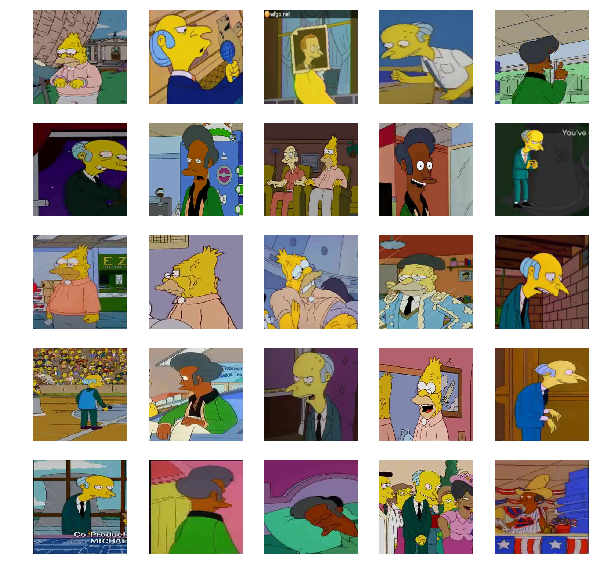

In [11]:
i_= 0
for i in np.random.randint(low=0,high=X_train.shape[0],size=25):
    plt.subplot(5, 5,i_+1)
    plt.imshow(np.rollaxis(X_train[i],0,3))
    plt.axis('off')
    i_ = i_+ 1

### Data Augmentation 

Increase the dataset using slight trasformation to increase the training size. Skipping the transformation

In [12]:
def augment_images(Image):
    #This function will randomly select one of the transformation 
    choice = np.random.choice(5)
    if choice == 0:
        return dotranslate(image)
    if choice == 1:
        return dorotation(image)
    if choice == 2:
        return dotranslate(image)

## CNN Model using PyTorch

In [13]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

Lets apply CNN model using pytorch 

In [14]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [15]:
xtrain_tensor = torch.from_numpy(X_train)
ytrain_tensor = torch.from_numpy(Y_train)
xtest_tensor = torch.from_numpy(X_test)
ytest_tensor = torch.from_numpy(Y_test)

In [16]:
print(xtrain_tensor.size())
print(ytrain_tensor.size())
print(xtest_tensor.size())
print(ytest_tensor.size())

torch.Size([2429, 3, 256, 256])
torch.Size([2429])
torch.Size([300, 3, 256, 256])
torch.Size([300])


In [17]:
#Hyperparmeters
learn_rate = 10**-5
#momentum = 0.90
batch_size = 32
c_first_l = 42
c_second_l = 51
c_third_l = 60  
c_fourth_l = 34
fc1_nn_op = 75
fc2_nn_op = 17

In [18]:
learn_rate

1e-05

### Architecture of CNN 

We have convolution layer as follow :

(256,256,3) *-conv1-relu->* (252,252,c_first_l) *-conv2-relu->* (248,248,c_second_l) *-maxpool->* (124,124,c_second_l) *-dropout->* (124,124,c_second_l)
(124,124,c_second_l) *-conv3-relu->* (120,120,c_third_l) *-conv4-relu->* (116,116,c_four_l) *-maxpool->* (58,58,c_fourth_l)

followed by 2 Fully connected layer


In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        #padding 0 is same size conv
        self.conv1 = nn.Conv2d(in_channels = 3,out_channels = c_first_l,kernel_size = 5, stride = 1, padding = 0)
        self.conv2 = nn.Conv2d(in_channels = c_first_l,out_channels = c_second_l,kernel_size = 5, stride = 1, padding = 0)
        self.conv3 = nn.Conv2d(in_channels = c_second_l,out_channels = c_third_l,kernel_size = 5, stride = 1, padding = 0)
        self.conv2_drop = nn.Dropout2d(p=0.7)
        self.conv4 = nn.Conv2d(in_channels = c_third_l,out_channels = c_fourth_l,kernel_size = 5, stride = 1, padding = 0)
        self.fc1 = nn.Linear(58 * 58 * c_fourth_l,fc1_nn_op)
        self.fc2 = nn.Linear(fc1_nn_op,fc2_nn_op)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)),kernel_size=2,stride=2) 
        x = self.conv2_drop(x)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(F.relu(self.conv4(x)),kernel_size=2,stride=2) 
        x = x.view(-1,self.get_flat_feature_count(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x ##CrossEntropy need raw o/p
    
    def get_flat_feature_count(self,x):
        size = x.size()[1:]
        count = 1
        for s in size:
            count *=s
        return count

In [20]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 42, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(42, 51, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(51, 60, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.7)
  (conv4): Conv2d(60, 34, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=114376, out_features=75, bias=True)
  (fc2): Linear(in_features=75, out_features=17, bias=True)
)


In [21]:
if torch.cuda.is_available():
    net.cuda()

In [22]:
net.float()

Net(
  (conv1): Conv2d(3, 42, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(42, 51, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(51, 60, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.7)
  (conv4): Conv2d(60, 34, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=114376, out_features=75, bias=True)
  (fc2): Linear(in_features=75, out_features=17, bias=True)
)

In [23]:
import torch.optim as optim
import torch
import torch.utils.data
import shutil

In [24]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learn_rate)

In [26]:
#Approach 2 : Using dataLoader
train_data = list(zip(X_train,Y_train))
train_data_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=5)

In [27]:
"""Number_iteration = 200
for epochs in range(Number_iteration):
    for i,data in enumerate(train_data_loader):
        xtrain,ytrain = data
        if not torch.is_tensor(ytrain):
                ytrain = torch.Tensor(int(ytrain))
        xtrain = xtrain.type(torch.FloatTensor)
        ytrain = ytrain.type(torch.LongTensor)
        if torch.cuda.is_available:
                xtrain,ytrain = xtrain.cuda(),ytrain.cuda()
        xtrain,ytrain=Variable(xtrain),Variable(ytrain)
        optimizer.zero_grad()
        output = net(xtrain)
        loss = criterion(output,ytrain)
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print('Epoch[%d/%d],Iter [%d/%d] Loss: %.4f'%(epoch,Number_iteration,i,len(X_train)//batch_size,loss.data[0]))"""

"Number_iteration = 200\nfor epochs in range(Number_iteration):\n    for i,data in enumerate(train_data_loader):\n        xtrain,ytrain = data\n        if not torch.is_tensor(ytrain):\n                ytrain = torch.Tensor(int(ytrain))\n        xtrain = xtrain.type(torch.FloatTensor)\n        ytrain = ytrain.type(torch.LongTensor)\n        if torch.cuda.is_available:\n                xtrain,ytrain = xtrain.cuda(),ytrain.cuda()\n        xtrain,ytrain=Variable(xtrain),Variable(ytrain)\n        optimizer.zero_grad()\n        output = net(xtrain)\n        loss = criterion(output,ytrain)\n        loss.backward()\n        optimizer.step()\n        if (i+1) % 100 == 0:\n            print('Epoch[%d/%d],Iter [%d/%d] Loss: %.4f'%(epoch,Number_iteration,i,len(X_train)//batch_size,loss.data[0]))"

In [28]:
def train_net(net,Number_iteration):
    net.zero_grad() # Zero the acc gradient
    loss_ = []
    net.train()
    for epoch in range(Number_iteration):
        permutation_ = torch.randperm(xtrain_tensor.size()[0]) #make sure all are there
        for i in range(0,xtrain_tensor.size()[0],batch_size):
            optimizer.zero_grad()
            indices = permutation_[i:i+batch_size]
            batch_x, batch_y = xtrain_tensor[indices], ytrain_tensor[indices]
            #unknown issue with Double so changing to Float
            batch_x = batch_x.type(torch.FloatTensor)
            batch_y = batch_y.type(torch.LongTensor)
            #best part of Torch
            if torch.cuda.is_available:
                batch_x,batch_y = batch_x.cuda(),batch_y.cuda()
            batch_x,batch_y=Variable(batch_x),Variable(batch_y)
            #true =torch.max(batch_y, 1)[1]#[32, 18, 1] to [32, 1]
            output = net.forward(batch_x)

            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            loss_.append(loss.data[0])
            if (epoch+1) % 5 == 0:
                print('Epoch[%d/%d],Iter [%d/%d] Loss: %.4f'%(epoch,Number_iteration,i,len(X_train)//batch_size,loss.data[0]))

In [49]:
def eval_net(net):
    net.eval()
    test_loss =0
    total_n =0
    correct_n = 0
    for i in range(0,xtest_tensor.size()[0],batch_size):
        if batch_size+i < xtest_tensor.size()[0]:
            batch_x = xtest_tensor[i:batch_size+i].type(torch.FloatTensor)
            batch_y = ytest_tensor[i:batch_size+i].type(torch.LongTensor)
        else:
            batch_x = xtest_tensor[i:].type(torch.FloatTensor)
            batch_y = ytest_tensor[i:].type(torch.LongTensor)
        if torch.cuda.is_available:
                    batch_x,batch_y = batch_x.cuda(), batch_y.cuda()
        batch_x = Variable(batch_x)
        output = net.forward(batch_x)
        _, predicted = torch.max(output.data, 1)
        total_n += batch_y.size(0)
        correct_n += (predicted == batch_y).sum()
        
    test_loss = correct_n/total_n *100
    print("Accuracy Final %: ",round(test_loss,2))


In [31]:
train_net(net,50)

Epoch[4/50],Iter [0/75] Loss: 1.0126
Epoch[4/50],Iter [32/75] Loss: 0.7243
Epoch[4/50],Iter [64/75] Loss: 0.7953
Epoch[4/50],Iter [96/75] Loss: 0.8923
Epoch[4/50],Iter [128/75] Loss: 0.6297
Epoch[4/50],Iter [160/75] Loss: 0.8654
Epoch[4/50],Iter [192/75] Loss: 0.6690
Epoch[4/50],Iter [224/75] Loss: 0.6456
Epoch[4/50],Iter [256/75] Loss: 0.8821
Epoch[4/50],Iter [288/75] Loss: 0.6542
Epoch[4/50],Iter [320/75] Loss: 0.7138
Epoch[4/50],Iter [352/75] Loss: 0.9002
Epoch[4/50],Iter [384/75] Loss: 0.7552
Epoch[4/50],Iter [416/75] Loss: 0.6694
Epoch[4/50],Iter [448/75] Loss: 0.6014
Epoch[4/50],Iter [480/75] Loss: 0.8078
Epoch[4/50],Iter [512/75] Loss: 0.6816
Epoch[4/50],Iter [544/75] Loss: 0.7209
Epoch[4/50],Iter [576/75] Loss: 0.7267
Epoch[4/50],Iter [608/75] Loss: 0.9759
Epoch[4/50],Iter [640/75] Loss: 0.6765
Epoch[4/50],Iter [672/75] Loss: 0.8304
Epoch[4/50],Iter [704/75] Loss: 0.5589
Epoch[4/50],Iter [736/75] Loss: 0.4880
Epoch[4/50],Iter [768/75] Loss: 0.6390
Epoch[4/50],Iter [800/75] Loss

Epoch[14/50],Iter [1792/75] Loss: 0.7622
Epoch[14/50],Iter [1824/75] Loss: 0.6428
Epoch[14/50],Iter [1856/75] Loss: 0.5730
Epoch[14/50],Iter [1888/75] Loss: 0.8077
Epoch[14/50],Iter [1920/75] Loss: 0.7280
Epoch[14/50],Iter [1952/75] Loss: 1.0262
Epoch[14/50],Iter [1984/75] Loss: 0.8317
Epoch[14/50],Iter [2016/75] Loss: 0.5345
Epoch[14/50],Iter [2048/75] Loss: 0.6160
Epoch[14/50],Iter [2080/75] Loss: 0.6276
Epoch[14/50],Iter [2112/75] Loss: 0.6850
Epoch[14/50],Iter [2144/75] Loss: 0.5738
Epoch[14/50],Iter [2176/75] Loss: 0.4844
Epoch[14/50],Iter [2208/75] Loss: 0.6317
Epoch[14/50],Iter [2240/75] Loss: 0.7225
Epoch[14/50],Iter [2272/75] Loss: 0.5848
Epoch[14/50],Iter [2304/75] Loss: 0.5700
Epoch[14/50],Iter [2336/75] Loss: 0.7350
Epoch[14/50],Iter [2368/75] Loss: 0.7703
Epoch[14/50],Iter [2400/75] Loss: 0.5595
Epoch[19/50],Iter [0/75] Loss: 0.6174
Epoch[19/50],Iter [32/75] Loss: 0.7088
Epoch[19/50],Iter [64/75] Loss: 0.5694
Epoch[19/50],Iter [96/75] Loss: 0.6555
Epoch[19/50],Iter [128/75

Epoch[34/50],Iter [1152/75] Loss: 0.4391
Epoch[34/50],Iter [1184/75] Loss: 0.4665
Epoch[34/50],Iter [1216/75] Loss: 0.3579
Epoch[34/50],Iter [1248/75] Loss: 0.4047
Epoch[34/50],Iter [1280/75] Loss: 0.4696
Epoch[34/50],Iter [1312/75] Loss: 0.2440
Epoch[34/50],Iter [1344/75] Loss: 0.3716
Epoch[34/50],Iter [1376/75] Loss: 0.3838
Epoch[34/50],Iter [1408/75] Loss: 0.3158
Epoch[34/50],Iter [1440/75] Loss: 0.4410
Epoch[34/50],Iter [1472/75] Loss: 0.6418
Epoch[34/50],Iter [1504/75] Loss: 0.4416
Epoch[34/50],Iter [1536/75] Loss: 0.4534
Epoch[34/50],Iter [1568/75] Loss: 0.5291
Epoch[34/50],Iter [1600/75] Loss: 0.5038
Epoch[34/50],Iter [1632/75] Loss: 0.4296
Epoch[34/50],Iter [1664/75] Loss: 0.3645
Epoch[34/50],Iter [1696/75] Loss: 0.3711
Epoch[34/50],Iter [1728/75] Loss: 0.1965
Epoch[34/50],Iter [1760/75] Loss: 0.6091
Epoch[34/50],Iter [1792/75] Loss: 0.3944
Epoch[34/50],Iter [1824/75] Loss: 0.4382
Epoch[34/50],Iter [1856/75] Loss: 0.4092
Epoch[34/50],Iter [1888/75] Loss: 0.2429
Epoch[34/50],Ite

Epoch[49/50],Iter [320/75] Loss: 0.2109
Epoch[49/50],Iter [352/75] Loss: 0.5388
Epoch[49/50],Iter [384/75] Loss: 0.2493
Epoch[49/50],Iter [416/75] Loss: 0.3624
Epoch[49/50],Iter [448/75] Loss: 0.2914
Epoch[49/50],Iter [480/75] Loss: 0.2988
Epoch[49/50],Iter [512/75] Loss: 0.2106
Epoch[49/50],Iter [544/75] Loss: 0.5023
Epoch[49/50],Iter [576/75] Loss: 0.2809
Epoch[49/50],Iter [608/75] Loss: 0.2776
Epoch[49/50],Iter [640/75] Loss: 0.2389
Epoch[49/50],Iter [672/75] Loss: 0.4247
Epoch[49/50],Iter [704/75] Loss: 0.2552
Epoch[49/50],Iter [736/75] Loss: 0.3428
Epoch[49/50],Iter [768/75] Loss: 0.3794
Epoch[49/50],Iter [800/75] Loss: 0.3491
Epoch[49/50],Iter [832/75] Loss: 0.3097
Epoch[49/50],Iter [864/75] Loss: 0.4417
Epoch[49/50],Iter [896/75] Loss: 0.2389
Epoch[49/50],Iter [928/75] Loss: 0.4505
Epoch[49/50],Iter [960/75] Loss: 0.4061
Epoch[49/50],Iter [992/75] Loss: 0.2957
Epoch[49/50],Iter [1024/75] Loss: 0.4435
Epoch[49/50],Iter [1056/75] Loss: 0.3072
Epoch[49/50],Iter [1088/75] Loss: 0.46

In [50]:
eval_net(net)

Accuracy Final %:  82.33


In [51]:
torch.save(net.state_dict(), 'cnn_50_only.pkl')